In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp
from astropy.wcs import WCS
import glob
from astropy.coordinates import SkyCoord
from tqdm import tqdm

In [2]:
#set desired nside
nside = 8192

all_sky_map = np.zeros(hp.nside2npix(nside), dtype = np.float32)
weight_map = np.zeros(hp.nside2npix(nside), dtype = np.int16)

In [3]:
#read_maps
all_maps = np.array(glob.glob("NVSS/MAPS/*")) #path to data
n = len(all_maps)

In [4]:
#create all-sky map
for i in tqdm(np.arange(n)):
    
    hdulist=fits.open(all_maps[i])
    image = hdulist[0].data
    header = hdulist[0].header
    hdulist.close()
    
    image = image[0,0,0:1024,:] #only for NVSS
    nypix = image.shape[0]
    nxpix = image.shape[1]
    
    w = WCS(header, naxis=2)
    YY, XX = np.indices((nypix, nxpix))
    RA, DEC = w.wcs_pix2world(XX, YY, 0)
    
    c = SkyCoord(RA, DEC, frame='fk5', unit='deg')
    c_gal = c.transform_to('galactic')
    glon = c_gal.l.degree
    glat = c_gal.b.degree
    
    index = hp.ang2pix(nside, glon, glat, lonlat=True)
    
    all_sky_map[index.reshape(nypix*nxpix)] += image.reshape(nypix*nxpix)
    weight_map[index.reshape(nypix*nxpix)] += 1

  0%|          | 0/2326 [00:00<?, ?it/s]WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 49327.000000 from DATE-OBS.
Changed DATE-OBS from '06/12/93' to '1993-12-06''. [astropy.wcs.wcs]
  0%|          | 1/2326 [00:00<12:50,  3.02it/s]WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 49363.000000 from DATE-OBS.
Changed DATE-OBS from '11/01/94' to '1994-01-11''. [astropy.wcs.wcs]
  0%|          | 3/2326 [00:00<11:52,  3.26it/s]WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 49823.000000 from DATE-OBS.
Changed DATE-OBS from '16/04/95' to '1995-04-16''. [astropy.wcs.wcs]
  0%|          | 5/2326 [00:01<11:21,  3.41it/s]WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 49732.000000 from DATE-OBS.
Changed DATE-OBS from '15/01/95' to '1995-01-15''. [astropy.wcs.wcs]
  0%|          | 9/2326 [00:02<10:48,  3.57it/s]WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 49776.000000 from DATE-OBS.
Changed DATE

In [5]:
hp.write_map("weight.fits", weight_map, dtype = np.int16, overwrite=True)
hp.write_map("map.fits", all_sky_map, dtype = np.float32, overwrite=True)

In [6]:
null = weight_map == 0
legit = weight_map != 0
all_sky_map[null] = hp.UNSEEN
all_sky_map[legit] /= weight_map[legit]

In [7]:
hp.write_map("weight2.fits", weight_map, dtype = np.int16, overwrite=True)
hp.write_map("map2.fits", all_sky_map, dtype = np.float32, overwrite=True)

In [8]:
all_sky_map_smoothed = hp.smoothing(all_sky_map, fwhm= 10/60 * np.pi/180, iter = 0)
all_sky_map_smoothed[null] = hp.UNSEEN
all_sky_map_smoothed_downgraded = hp.ud_grade(all_sky_map_smoothed, nside_out = 2048)

/home/jens/Software/anaconda3/lib/python3.7/site-packages/healpy-1.12.9-py3.7-linux-x86_64.egg/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/jens/Software/anaconda3/lib/python3.7/site-packages/healpy-1.12.9-py3.7-linux-x86_64.egg/healpy/sphtfunc.py:714: RuntimeWarning: invalid value encountered in sqrt
  almout = _sphtools.almxfl(alm, fl, mmax=mmax, inplace=inplace)


In [10]:
hp.write_map("map_downgraded.fits", all_sky_map_smoothed_downgraded)

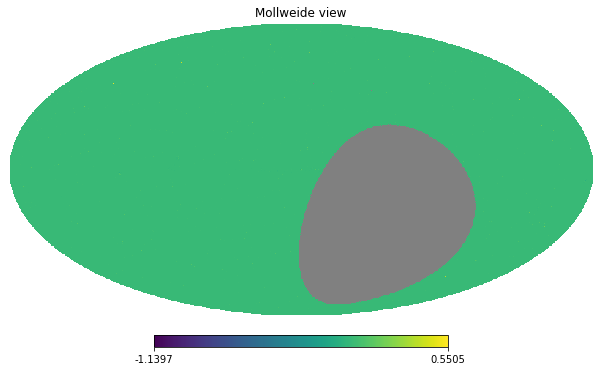

In [15]:
hp.mollview(all_sky_map)

In [13]:
all_sky_map_smoothed_downgraded

array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
       -1.6375e+30, -1.6375e+30])

In [16]:
10/60 * np.pi/180

0.0029088820866572155